In [ ]:
#default_exp losses.gw_test

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# Giacomini-White Test

Test on out-of-sample conditional predictive ability.

References:
- Giacomini, R., & White, H. (2006). Tests of conditional predictive ability. Econometrica, 74(6), 1545-1578.
- https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1468-0262.2006.00718.x
- http://www.runmycode.org/companion/view/88

## Newey-West estimator

Estimator of the Newey-West Heteroskedasticity and Autocorrelation Consistent Covariance Matrix (Newey-West HAC) to calculate robust error estimations.

In [ ]:
#export
import os
import numpy as np
from scipy.stats.distributions import chi2

from typing import List

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import rcParams
plt.rcParams['font.family'] = 'serif'

FONTSIZE = 17

In [ ]:
# export
def Newey_West(Z, n_lags):
    """ Newey-West HAC estimator
    Parameters
    ----------
    Z: (n, k) ndarray
    n_lags: int
        number of lags to consider as available information.

    Returns
    -------
    omega_hat: Newey-West HAC estimator of the covariance matrix
    """

    assert n_lags > 0

    n, k = Z.shape

    Z = Z - np.ones((n, 1)) * np.mean(Z, axis=0)
    gamma = -999 * np.ones((n_lags, k))
    omega_hat = (1/n) * np.matmul(np.transpose(Z), Z)

    Zlag = np.array([np.pad(Z, ((i,0), (0,0)), mode='constant', 
                            constant_values = 0)[:n] 
                     for i in range(1, n_lags + 1)])
    gamma = (1/n) * (np.matmul(np.transpose(Z), Zlag) + 
            np.matmul(np.einsum('ijk -> ikj', Zlag), Z))
    weights = 1 - np.array(range(1,n_lags + 1))/(n_lags + 1)
    omega_hat = omega_hat + \
                np.sum(gamma * np.expand_dims(weights, 
                                              axis = (1,2)), 
                                              axis = 0)
    return omega_hat

In [ ]:
# export
def GW_CPA_test(loss1: np.ndarray, 
                loss2: np.ndarray, 
                tau: int,
                alpha: float=0.05,
                unconditional: bool=True,
                verbose: bool=True):
    """ 
    Giacomini-White Conditional Predictive Ability Test
    Parameters
    ----------
    loss1: numpy array
        losses of model 1
    loss2: numpy array
        losses of model 2
    tau: int
        the past information treated as 'available' for the test.
    unconditional: boolean, 
        True if unconditional (DM test), False if conditional (GW test).
    verbose: boolean, 
        True if prints of test are needed

    Returns
    -------
    test_stat: test statistic of the conditional predictive ability test
    crit_val: critical value of the chi-square test for a 5% confidence level
    p-vals: (k,) p-value of the test
    """   

    assert len(loss1) == len(loss2)

    lossdiff = loss1 - loss2
    t = len(loss1)
    instruments = np.ones_like(loss1)

    if not unconditional:
        instruments = np.hstack((instruments[:t-tau], 
                                 lossdiff[:-tau]))
        lossdiff = lossdiff[tau:]
        t = t - tau

    reg = instruments * lossdiff
    
    if tau == 1:

        res_beta = np.linalg.solve(reg.T.dot(reg), 
                                   reg.T.dot(np.ones((t,1))))
        err = np.ones((t,1)) - reg.dot(res_beta)
        r2 = 1 - np.mean(err**2)
        test_stat = t * r2
        q = reg.shape[1]
        crit_val = chi2.ppf(1-alpha, df=q)
        p_val = 1 - chi2.cdf(np.abs(test_stat), q)
    
    else:

        zbar = np.mean(reg, axis=0)
        n_lags = tau - 1
        omega = Newey_West(Z=reg, n_lags=n_lags)
        test_stat = np.expand_dims(t*zbar, 
                                   axis=0).dot(np.linalg.inv(omega)).\
                                   dot(zbar)
        q = reg.shape[1]
        crit_val = chi2.ppf(1-alpha, df=q)
        p_val = 1 - chi2.cdf(np.abs(test_stat), q)

    av_diff_loss = np.mean(loss1-loss2)
    s = '+' if np.mean(loss1-loss2) > 0 else '-'
    
    if verbose:
        if unconditional: print('\nUnconditional test:\n')
        if not unconditional: print('\nConditional test:\n')
        print(f'Forecast horizon: {tau}, Nominal Risk Level: {alpha}')
        print(f'Test-statistic: {test_stat} ({s})')
        print(f'Critical value: {crit_val}')
        print(f'p-value: {p_val}\n')
    return test_stat, crit_val, p_val


In [ ]:
np.random.seed(1)

loss1 = np.random.randint(low=1, high=10, size=(10,1))
loss2 = np.random.randint(low=1, high=10, size=(10,1))

GW_CPA_test(loss1=loss1, loss2=loss2, tau=1, unconditional=False)


Conditional test:

Forecast horizon: 1, Nominal Risk Level: 0.05
Test-statistic: 0.06536064947319875 (-)
Critical value: 5.991464547107979
p-value: 0.96784790717567



(0.06536064947319875, 5.991464547107979, 0.96784790717567)

In [ ]:
# export
def GW_p_values(y: np.ndarray,
                y_hat: np.ndarray,
                horizon: int,
                tau: int,                
                unconditional: bool,
                alpha: float=0.05,
                verbose: bool=False):
    """ Function to calculate model-pair-wise GW-Test p-values
    Parameters
    ----------
    y: numpy array
        flat array with actual test values
    y_hat: numpy array
        matrix with predicted values
    model_names: string list 
        with the names of the models.
    horizon: int
        the multi horizon for which the predictions were created, 
        the test is performed against over the mean differences 
        in said multi horizon losses.
    tau: int
        the past information treated as 'available' for the test.
    alpha: float 
        level of significance for the test.
    unconditional: boolean, 
        True if unconditional (DM test), False if conditional (GW test).
    verbose: boolean.
        True for partial test results.

    Returns
    -------
    p_vals: (n_models, n_models) 
            symmetric numpy array with the model-pair-wise p-values.
    
    """
    # number of date stamps and de facto forecast creation dates
    n_ds, n_models = y_hat.shape
    n_fcds = n_ds // horizon

    # multi horizon losses
    losses = np.abs(y - y_hat)
    losses = losses.reshape(n_fcds, n_models, horizon)
    losses = np.mean(losses, axis=2)

    p_values = np.zeros((n_models, n_models))

    for i in range(n_models):
        loss1 = losses[:, [i]]
        for j in range(i):
            loss2 = losses[:, [j]]
            _, _, p_val = GW_CPA_test(loss1=loss1,
                                      loss2=loss2,
                                      tau=1,
                                      alpha=alpha,
                                      unconditional=unconditional,
                                      verbose=verbose)



            p_values[i,j] = p_val
            p_values[j,i] = p_val

    return p_values

In [ ]:
# export
def plot_GW_test(y: np.ndarray,
                 y_hat: np.ndarray,
                 horizon: int,
                 tau: int,
                 model_names: List[str],
                 title: str,
                 unconditional: bool,
                 alpha=0.05):

    p_values = GW_p_values(y=y, y_hat=y_hat,
                           horizon=horizon, tau=tau,
                           unconditional=unconditional,
                           alpha=alpha)
        
    fig, ax = plt.subplots(figsize=(6, 6))

    #im = ax.imshow(p_values, cmap=plt.get_cmap('GnBu'), vmin=0, vmax=0.1)
    im = ax.imshow(p_values, cmap=plt.get_cmap('GnBu_r'), vmin=0, vmax=0.1)

    # Colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    # Ticks and labels
    assert len(model_names) == p_values.shape[1]
    ax.set_xticks(np.arange(p_values.shape[1]))
    ax.set_yticks(np.arange(p_values.shape[1]))

    ax.set_xticklabels(model_names, fontsize=FONTSIZE)
    ax.set_yticklabels(model_names, fontsize=FONTSIZE)

    for i in range(len(model_names)):
        text = ax.text(i, i, 'x',
                        ha="center", va="center", color="w")

    plt.setp(ax.get_xticklabels(), rotation=90, 
                ha="right", rotation_mode="anchor")

    ax.set_title(title, fontweight='bold', fontsize=FONTSIZE)
    fig.tight_layout()
    plt.show()


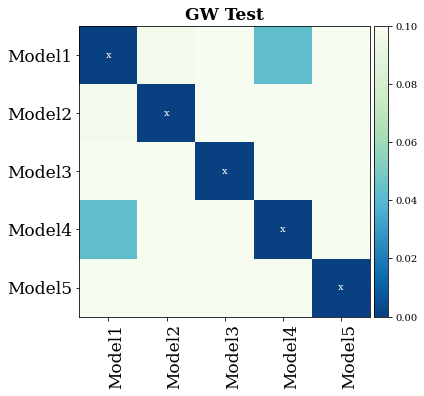

In [ ]:
np.random.seed(1)

# Observed values for 3 different days
y = np.random.randint(low=1, high=10, size=(100*24, 1)) 

# Predicted values for 3 different days, from 5 different models
y_hat = np.random.randint(low=1, high=10, size=(100*24, 5))
model_names = ['Model1', 'Model2', 'Model3', 'Model4', 'Model5']

p_values = plot_GW_test(y=y, y_hat=y_hat,
                        horizon=24, tau=1, 
                        model_names=model_names,
                        title='GW Test',
                        unconditional=True)